<a href="https://colab.research.google.com/github/MrOnie/DeepLearning/blob/master/LanguageModels_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio: Modelos del lenguaje con RNNs

Resuelto por:
- Diego Felipe Zabaleta Arias
- Ronie Martinez Gordon

En este laboratorio, vamos a entrenar un modelo del lenguaje basado en caracteres con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos en este laboratorio para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar este laboratorio con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)

[Compilación de obras teatrales (Calderón de la Barca)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219433&authkey=AKvGD6DC3IRBqmc)

[Trafalgar (Benito Pérez Galdós)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ)

Como ya deberíamos de estar acostumbrados en problemas de Machine Learning, es importante echar un vistazo a los datos antes de empezar.

## 1. Carga y procesado del texto

Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en .txt del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [0]:
import numpy as np 
import keras
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import random
import io
%tensorflow_version 2.x magic:

path = keras.utils.get_file(
    fname="don_quijote.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io"
)

Using TensorFlow backend.


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x magic:`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2154496/2151176 [==============================] - 1s 0us/step


Una vez descargado, vamos a leer el contenido del fichero en una variable. Adicionalmente, convertiremos el contenido del texto a minúsculas para ponérselo un poco más fácil a nuestro modelo (de modo que todas las letras sean minúsculas y el modelo no necesite diferenciar entre minúsculas y mayúsculas).

**1.1.** Leer todo el contenido del fichero en una única variable ***text*** y convertir el string a minúsculas

In [0]:
fichero = open(path, 'r', encoding="utf8") # Abrir fichero. Lectura.
fichero_str = fichero.read() # Lectura del fichero
text = fichero_str.lower() # cambiar a minúscula

Podemos comprobar ahora que efectivamente nuestra variable contiene el resultado deseado, con el comienzo tan característico del Quijote.

In [0]:
print("Longitud del texto: {}".format(len(text)))
text2 = text[0:300] # Para pruebas
print(text2)

Longitud del texto: 2071198
capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más


## 2. Procesado de los datos

Una de las grandes ventajas de trabajar con modelos que utilizan caracteres en vez de palabras es que no necesitamos tokenizar el texto (partirlo palabra a palabra). Nuestro modelo funcionará directamente con los caracteres en el texto, incluyendo espacios, saltos de línea, etc.

Antes de hacer nada, necesitamos procesar el texto en entradas y salidas compatibles con nuestro modelo. Como sabemos, un modelo del lenguaje con RNNs acepta una serie de caracteres y predice el siguiente carácter en la secuencia.

* "*El ingenioso don Qui*" -> predicción: **j**
* "*El ingenioso don Quij*" -> predicción: **o**

De modo que la entrada y la salida de nuestro modelo necesita ser algo parecido a este esquema. En este punto, podríamos usar dos formas de preparar los datos para nuestro modelo.

1. **Secuencia a secuencia**. La entrada de nuestro modelo sería una secuencia y la salida sería esa secuencia trasladada un caracter a la derecha, de modo que en cada instante de tiempo la RNN tiene que predecir el carácter siguiente. Por ejemplo:

>* *Input*:   El ingenioso don Quijot 
>* *Output*: l ingenioso don Quijote

2. **Secuencia a carácter**. En este variante, pasaríamos una secuencia de caracteres por nuestra RNN y, al llegar al final de la secuencia, predeciríamos el siguiente carácter.

>* *Input*:   El ingenioso don Quijot 
>* *Output*: e

En este laboratorio, por simplicidad, vamos a utilizar la segunda variante.

De este modo, a partir del texto, hemos de generar nuestro propio training data que consista en secuencias de caracteres con el siguiente carácter a predecir. Para estandarizar las cosas, utilizaremos secuencias de tamaño *SEQ_LENGTH* caracteres (un hiperparámetro que podemos elegir nosotros).



#### 2.1. Obtención de los caracteres y mapas de caracteres

Antes que nada, necesitamos saber qué caracteres aparecen en el texto, ya que tendremos que diferenciarlos mediante un índice de 0 a *num_chars* - 1 en el modelo. Obtener:
 

1.   Número de caracteres únicos que aparecen en el texto.
2.   Diccionario que asocia char a índice único entre 0 y *num_chars* - 1. Por ejemplo, {'a': 0, 'b': 1, ...}
3.   Diccionario reverso de índices a caracteres: {0: 'a', 1: 'b', ...}


In [0]:
# Espacios, saltos de línea, signos de puntuación, vocales con tilde
caracteres = []
diccionario = {}
diccionario_rev = {}
indice = 0

for letra in text:
  if letra in diccionario:
    pass #diccionario[letra]=diccionario[letra]+1 #contador
  else:
      caracteres.append(letra)
      diccionario[letra] = indice
      diccionario_rev[indice] = letra
      indice += 1

# Tamaño
print("Número de caracteres únicos: ", len(caracteres))

# Diccionario
print("Diccionario:")
print(diccionario)

# Diccionario reverso
print("Diccionario reverso:")
print(diccionario_rev)

Número de caracteres únicos:  61
Diccionario:
{'c': 0, 'a': 1, 'p': 2, 'í': 3, 't': 4, 'u': 5, 'l': 6, 'o': 7, ' ': 8, 'r': 9, 'i': 10, 'm': 11, 'e': 12, '.': 13, 'q': 14, 'd': 15, 'n': 16, 'ó': 17, 'y': 18, 'j': 19, 'f': 20, 's': 21, 'h': 22, 'g': 23, '\n': 24, ',': 25, 'b': 26, 'v': 27, 'z': 28, 'á': 29, 'ú': 30, 'ñ': 31, ';': 32, 'x': 33, 'é': 34, ':': 35, '-': 36, 'ü': 37, '¿': 38, "'": 39, '?': 40, '¡': 41, '!': 42, '«': 43, '»': 44, '(': 45, ')': 46, '"': 47, 'ï': 48, 'w': 49, ']': 50, 'à': 51, '1': 52, '0': 53, '7': 54, '6': 55, '5': 56, '2': 57, '3': 58, '4': 59, 'ù': 60}
Diccionario reverso:
{0: 'c', 1: 'a', 2: 'p', 3: 'í', 4: 't', 5: 'u', 6: 'l', 7: 'o', 8: ' ', 9: 'r', 10: 'i', 11: 'm', 12: 'e', 13: '.', 14: 'q', 15: 'd', 16: 'n', 17: 'ó', 18: 'y', 19: 'j', 20: 'f', 21: 's', 22: 'h', 23: 'g', 24: '\n', 25: ',', 26: 'b', 27: 'v', 28: 'z', 29: 'á', 30: 'ú', 31: 'ñ', 32: ';', 33: 'x', 34: 'é', 35: ':', 36: '-', 37: 'ü', 38: '¿', 39: "'", 40: '?', 41: '¡', 42: '!', 43: '«', 44: 

#### 2.2. Obtención de secuencias de entrada y carácter a predecir

Ahora, vamos a obtener las secuencias de entrada en formato texto y los correspondientes caracteres a predecir. Para ello, recorrer el texto completo leído anteriormente, obteniendo una secuencia de SEQ_LENGTH caracteres y el siguiente caracter a predecir. Una vez hecho, desplazarse un carácter a la izquierda y hacer lo mismo para obtener una nueva secuencia y predicción. Guardar las secuencias en una variable ***sequences*** y los caracteres a predecir en una variable ***next_chars***.

Por ejemplo, si el texto fuera "Don Quijote" y SEQ_LENGTH fuese 5, tendríamos

* *sequences* = ["Don Q", "on Qu", "n Qui", " Quij", "Quijo", "uijot"]
* *next_chars* = ['u', 'i', 'j', 'o', 't', 'e']

In [0]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 30

sequences = []
next_chars = []

## TU CÓDIGO AQUÍ
for i in range (len(text)-SEQ_LENGTH):
  #print(text[i:i+SEQ_LENGTH],text[i+SEQ_LENGTH])
  sequences.append(text[i:i+SEQ_LENGTH])
  next_chars.append(text[i+SEQ_LENGTH])

print(sequences[0:10])
print(next_chars[0:10])

['capítulo primero. que trata de', 'apítulo primero. que trata de ', 'pítulo primero. que trata de l', 'ítulo primero. que trata de la', 'tulo primero. que trata de la ', 'ulo primero. que trata de la c', 'lo primero. que trata de la co', 'o primero. que trata de la con', ' primero. que trata de la cond', 'primero. que trata de la condi']
[' ', 'l', 'a', ' ', 'c', 'o', 'n', 'd', 'i', 'c']


Indicar el tamaño del training set que acabamos de generar.

In [0]:
print("Tamaño del training set: ",len(sequences))

Tamaño del training set:  2071168


Como el Quijote es muy largo y tenemos muchas secuencias, podríamos encontrar problemas de memoria. Por ello, vamos a elegir un número máximo de ellas. Si estás corriendo esto localmente y tienes problemas de memoria, puedes reducir el tamaño aún más, pero ten cuidado porque, a menos datos, peor calidad del modelo.

In [0]:
MAX_SEQUENCES = 500000 #disminuir si hay problemas de memoria a <len(sequences)

perm = np.random.permutation(len(sequences))
sequences, next_chars = np.array(sequences), np.array(next_chars)
sequences, next_chars = sequences[perm], next_chars[perm]
sequences, next_chars = list(sequences[:MAX_SEQUENCES]), list(next_chars[:MAX_SEQUENCES])

print(len(sequences))

500000


#### 2.3. Obtención de input X y output y para el modelo

Finalmente, a partir de los datos de entrenamiento que hemos generado vamos a crear los arrays de datos X e y que pasaremos a nuestro modelo.

Para ello, vamos a utilizar *one-hot encoding* para nuestros caracteres. Por ejemplo, si sólo tuviéramos 4 caracteres (a, b, c, d), las representaciones serían: (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0) y (0, 0, 0, 1).

De este modo, **X** tendrá shape *(num_sequences, seq_length, num_chars)* e **y** tendrá shape *(num_sequences, num_chars)*. 



In [0]:
from keras.utils import np_utils
NUM_CHARS = len(caracteres)  # Tu número de caracteres distintos aquí
NUM_SEQUENCES = len(sequences)
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS))
y = np.zeros((NUM_SEQUENCES, NUM_CHARS))

## Tu código para rellenar X e y aquí. Pista: utilizar el diccionario de
## chars a índices obtenido anteriormente junto con numpy. Por ejemplo,
## si hacemos 
##     X[0, 1, char_to_indices['a']] = 1
## estamos diciendo que para la segunda posición de la primera secuencia se
## tiene una 'a'

## TU CÓDIGO AQUÍ
print (X.shape)
print (y.shape)

integer_encoded = [diccionario[char] for char in caracteres]

onehot_encoded = list()
for value in integer_encoded:
    letter = [0 for _ in range(len(caracteres))]
    letter[value] = 1
    onehot_encoded.append(letter)

for i in range(len(X)):
  for j in range(len(X[i])):
    X[i][j]=onehot_encoded[diccionario[sequences[i][j]]]

for i in range(len(y)):
  y[i]=onehot_encoded[diccionario[next_chars[i]]]

(500000, 30, 61)
(500000, 61)


## 3. Definición del modelo y entrenamiento

Una vez tenemos ya todo preparado, es hora de definir el modelo. Define un modelo que utilice una **LSTM** con **128 unidades internas**. Si bien el modelo puede definirse de una manera más compleja, para empezar debería bastar con una LSTM más una capa Dense con el *softmax* que predice el siguiente caracter a producir. Adam puede ser una buena elección de optimizador.

Una vez el modelo esté definido, entrénalo un poco para asegurarte de que la loss es decreciente. No es necesario guardar la salida de este entrenamiento en el entregable final, ya que vamos a hacer el entrenamiento más informativo en el siguiente punto.

In [0]:
## Modelo
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]))) #128 unidades internas
model.add(Dense(y.shape[1], activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.fit(X, y, epochs=10, batch_size=128)
#Se detiene el entrenamiento, luego de confirmar que la loss decrece




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               97280     
_________________________________________________________________
dense_1 (Dense)              (None, 61)                7869      
Total params: 105,149
Trainable params: 105,149
Non-trainable params: 0
_________________________________________________________________




Para ver cómo evoluciona nuestro modelo del lenguaje, vamos a generar texto según va entrenando. Para ello, vamos a programar una función que, utilizando el modelo en su estado actual, genere texto, con la idea de ver cómo se va generando texto al entrenar cada epoch.

En el código de abajo podemos ver una función auxiliar para obtener valores de una distribución multinomial. Esta función se usará para muestrear el siguiente carácter a utilizar según las probabilidades de la salida de softmax (en vez de tomar directamente el valor con la máxima probabilidad, obtenemos un valor aleatorio según la distribución de probabilidad dada por softmax, de modo que nuestros resultados serán más diversos, pero seguirán teniendo "sentido" ya que el modelo tenderá a seleccionar valores con más probabilidad).



In [0]:
def sample(probs, temperature=1.0):
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.
    
    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]
      
      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados. 
        
        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')
    
    # Hacemos logaritmo de probabilidades y aplicamos reducción
    # por temperatura.
    probs = np.log(probs) / temperature
    
    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)
    
    # Hacemos el sampling dadas las nuevas probabilidades
    # de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    return np.argmax(samples)


Utilizando la función anterior y el modelo entrenado, vamos a añadir un callback a nuestro modelo para que, según vaya entrenando, veamos los valores que resultan de generar textos con distintas temperaturas al acabar cada epoch.

Para ello, abajo tenéis disponible el callback *on_epoch_end*. Esta función elige una secuencia de texto al azar en el texto disponible en la variable
text y genera textos de longitud *GENERATED_TEXT_LENGTH* según las temperaturas en *TEMPERATURES_TO_TRY*, utilizando para ello la función *generate_text*.

Completa la función *generate_text* de modo que utilicemos el modelo y la función sample para generar texto.

NOTA: Cuando hagas model.predict, es aconsejable usar verbose=0 como argumento para evitar que la función imprima valores de salida.

In [0]:
TEMPERATURES_TO_TRY = [0.2, 0.5, 1.0, 1.2]
GENERATED_TEXT_LENGTH = 300

def generate_text(seed_text, model, length, temperature=1):
    """Genera una secuencia de texto a partir de seed_text utilizando model.
    
    La secuencia tiene longitud length y el sampling se hace con la temperature
    definida.
    """
    
    # Aquí guardaremos nuestro texto generado, que incluirá el
    # texto origen
    generated = seed_text
    
    # Utilizar el modelo en un bucle de manera que generemos
    # carácter a carácter. Habrá que construir los valores de
    # X_pred de manera similar a como hemos hecho arriba, salvo que
    # aquí sólo se necesita una oración
    # Nótese que el x que utilicemos tiene que irse actualizando con
    # los caracteres que se van generando. La secuencia de entrada al
    # modelo tiene que ser una secuencia de tamaño SEQ_LENGTH que
    # incluya el último caracter predicho.
 
    for i in range(length):
        xp = np.zeros((1, SEQ_LENGTH, len(caracteres)))       
        for j in range(len(xp[0])):
            xp[0][j]=onehot_encoded[diccionario[generated[j]]]        
        
        prediction = model.predict(xp, verbose=0)[0]
        index = sample(prediction, temperature)
        result = diccionario_rev[index]
        generated = generated + result       
        generated = generated[1:len(generated)]
        
        seed_text = seed_text + result
    return seed_text

def on_epoch_end(epoch, logs):
  print("\n\n\n")
  
  # Primero, seleccionamos una secuencia al azar para empezar a predecir
  # a partir de ella
  start_pos = random.randint(0, len(text) - SEQ_LENGTH - 1)
  seed_text = text[start_pos:start_pos + SEQ_LENGTH]
  for temperature in TEMPERATURES_TO_TRY:
    print("------> Epoch: {} - Generando texto con temperature {}".format(
        epoch + 1, temperature))
    
    generated_text = generate_text(seed_text, model, 
                                   GENERATED_TEXT_LENGTH, temperature)
    print("Seed: {}".format(seed_text))
    print("Texto generado: {}".format(generated_text))
    print()

generation_callback = LambdaCallback(on_epoch_end=on_epoch_end)  

Entrena ahora tu modelo. No te olvides de añadir *generation_callback* a la lista de callbacks utilizados en fit(). Ya que las métricas de clasificación no son tan críticas aquí (no nos importa tanto acertar el carácter exacto, sino obtener una distribución de probabilidad adecuada), no es necesario monitorizar la accuracy ni usar validation data, si bien puedes añadirlos para asegurarte de que todo está en orden.


In [0]:
#Entregable, generación con texto en cada epoch con diferentes temperaturas
model.fit(X, y, epochs=10, batch_size=128, callbacks=[generation_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





500000/500000 [==============================] - 180s 361us/step - loss: 2.1895 - acc: 0.3449




------> Epoch: 1 - Generando texto con temperature 0.2
Seed: , y, mirando si acaso estaba a
Texto generado: , y, mirando si acaso estaba a la mermera que se la me de la mería a la minte en la mería en con el caballero en que la mino de la mería me para de la mercienta de su la meras de la mencho en esto de su la con el con esta mería se con el conte de su mante de la merer estro en la minte de se para de la me me esto me haber al cond

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: , y, mirando si acaso estaba a
Texto generado: , y, mirando si acaso estaba al carallo que lo con mes cablesa el parla de la cuente, que los mestos que son el mabía me han hangon el codo la migar de que se la sencho, y con esto que secies y que su no mesto mis dos que san me vespordo, y 

Prueba: generación de texto.

In [0]:
#Generador para pruebas
start_pos = random.randint(0, len(text) - SEQ_LENGTH - 1)
seed_text = text[start_pos:start_pos + SEQ_LENGTH]
generated_text = generate_text(seed_text, model, GENERATED_TEXT_LENGTH, 0.5)
print("Texto generado: {}".format(generated_text))

Texto generado: go, no lleva pergenio de volver
en la verdad que se me parte en las pasas que el cura de mi señor con el gobernada y de don quijote y se puede para que el cura de la menos estarlos el mande estos prestosis, y no había sentiman de poso, por como la prosegue a ver para le suy de los pensandos de la caballero tran mala de su parte 


## Entregable

Completa los apartados anteriores para entrenar modelos del lenguaje que sean capaces de generar texto con cierto sentido. Comentar los resultados obtenidos y cómo el modelo va mejorando época a época. Comentar las diferencias apreciadas al utilizar diferentes valores de temperatura. Entregar al menos la salida de un entrenamiento completo con los textos generados época a época.

El objetivo no es conseguir generar pasajes literarios con coherencia, sino obtener lenguaje que se asemeje en cierta manera a lo visto en el texto original y donde las palabras sean reconocibles como construcciones en castellano. Como ejemplo de lo que se puede conseguir, este es el resultado de generar texto después de 10 epochs y con temperature 0.2:


```
-----> Epoch: 10 - Generando texto con temperature 0.2
Seed: o le cautivaron y rindieron el
Texto generado: o le cautivaron y rindieron el caballero de la caballería de la mano de la caballería del cual se le dijo:

-¿quién es el verdad de la caballería de la caballería de la caballería de la caballería de la caballería, y me ha de habían de la mano que el caballero de la mano de la caballería. y que no se le habían de la mano de la c

```

Asimismo, se proponen los siguientes aspectos opcionales para conseguir nota extra:

*   Experimentar con los textos de teatro en verso de Calderón de la Barca (¿es capaz el modelo de aprender las estructuras del teatro en verso?) o con alguno de los otros textos disponibles. También se puede probar con textos de vuestra elección.
*   Experimentar con distintos valores de SEQ_LENGTH.
*   Experimentar con los hiperparámetros del modelo o probar otro tipo de modelos como GRUs o *stacked* RNNs (RNNs apiladas).
*   Experimentar utilizando embeddings en vez de representaciones one-hot.
*   (Difícil) Entrenar un modelo secuencia a secuencia en vez de secuencia a carácter.




## Conclusión
A medida que el modelo avanza en su entrenamiento se nota que comete menos errores con las palabras, las frases no tienen sentido pero respeta la ortografia y estilos del escritor:

```
------> Epoch: 7 - Generando texto con temperature 0.5
Seed: os que, si cae en ellos, le ha
Texto generado: os que, si cae en ellos, le había en sus fintamos de caballería.

-¿con lo que el sino -dijo sancho-, a quieres contentar su casa le había de la merced de cuerpo el mandado que se le dicen se sobre de la caballería, y las labras de las desmancias de la mario
a la corazar de la esterma y hacer a su printo de los que en la visto d
```

Con respecto a la temperatura, a mayor valor se genera mas "basura", aparecen palabras que no existen y deja de obedecer orden gramatical. Tal como se comenta en la documentación de la función "sample": El valor de temperature = 1 nos da la distribución normal de softmax. Valores de temperature entre 0 y 1 hace que el sampling sea más conservador, mientras que para valores mayores a 1 hace que los samplings sean más atrevidos, es decir, elige con mayor frecuencia clases con baja probabilidad.

Como curiosidad, muchos resultados de las epochs con temerature = 0.2 utilizan la palabra "caballero" con alta frecuencia.

Utilizando Colab, cada epoch tarda en ejecutarse alrededor de 170 segundos, utilizando un train set de 500000 (el texto original es de tamaño 2071168). Además se utiliza en gran parte los recursos proporcionados por esta plataforma:
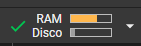